# PROJET 6 : partie 2 - Entrainement et Predictions


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Chargement des données

### Import des librairies

In [2]:
import pandas as pd
import os
import numpy as np
import urllib
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings("ignore")
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, naive_bayes, decomposition,multiclass, ensemble,preprocessing, metrics,linear_model
from sklearn import preprocessing
import mglearn
from mglearn import tools
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.externals import joblib
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

### Chargement de la Pipeline et d'autres données

In [3]:
current_path = os.getcwd()
parent_path = os.path.dirname(current_path)

X_train = joblib.load(parent_path + "\\pipeline\\X_train.pkl") 
X_test = joblib.load(parent_path + "\\pipeline\\X_test.pkl") 
y_train = joblib.load(parent_path + "\\pipeline\\y_train.pkl") 
y_test = joblib.load(parent_path + "\\pipeline\\y_test.pkl") 

data_train = joblib.load(parent_path + "\\pipeline\\data_train.pkl") 
data_test = joblib.load(parent_path + "\\pipeline\\data_test.pkl")

# dataframes et données
vectorizer = joblib.load(parent_path + "\\pipeline\\vectorizer.pkl")
count_tags_df = joblib.load(parent_path + "\\pipeline\\count_tags_df.pkl")
most_popular_tag = joblib.load(parent_path + "\\pipeline\\most_popular_tag.pkl")
unique_tags_serie = joblib.load(parent_path + "\\pipeline\\unique_tags_serie.pkl")
unique_tags = joblib.load(parent_path + "\\pipeline\\unique_tags.pkl")
selected_tags = joblib.load(parent_path + "\\pipeline\\selected_tags.pkl")

In [4]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(32271, 2512)
(10757, 2512)
(32271, 99)
(10757, 99)


## Fonctions liées à l'entrainement et aux tests

In [5]:
def get_lda_frequent_tags(row, min_frequency, most_frequent_tag):
    """
        Retourne les tags les plus fréqemment associés aux topics LDA
    """
    # Classement des lignes
    sorted_row = row.sort_values(ascending=False)
    
    # Test si au moins un Tag dépasse le seuil de fréquence minimum
    if sorted_row[0] >= min_frequency:
        acceptable_values = sorted_row[sorted_row >= min_frequency].index.values
        if len(acceptable_values) > 5 :
            output = acceptable_values[:5]
        else:
            output = acceptable_values
    # Sinon affichage du Tag le plus fréquent
    else:
        output = [most_frequent_tag]
    
    return output

In [6]:
def mean_local_recall(truth_pred_comparison_df, unique_tags_serie):
    """
    Fonction qui retourne la moyenne du Local_Recall
    """
    ### Moyenne du local_Recall #
    truth_pred_comparison_df['Local_Recall'] = truth_pred_comparison_df.apply(local_recall, axis=1)
    mean_local_recall = truth_pred_comparison_df.Local_Recall.mean()
    print("Recall moyen : %.2f" % mean_local_recall)
    return mean_local_recall
    

In [7]:
def other_scores(truth_pred_comparison_df, unique_tags_serie):
    """
    Fonction qui retourne le F1 Score, Recall et la précision
    """

    # Fractionnement des tags
    y_true_splitted = truth_pred_comparison_df.True_Tags.apply(lambda x: x.split("/"))
    y_pred_splitted = truth_pred_comparison_df.Predicted_Tags.apply(lambda x: x.split("/"))
    
    # Binarisation
    binarizer = preprocessing.MultiLabelBinarizer().fit(unique_tags_serie)

    # Métriques sur samples
    
    f1_score = metrics.f1_score(binarizer.transform(y_true_splitted),
                                binarizer.transform(y_pred_splitted),
                                average='samples')
    

    
    accuracy = metrics.precision_score(binarizer.transform(y_true_splitted),
                                binarizer.transform(y_pred_splitted),
                                average='samples')
    
    print("F1 Score : %.3f" % f1_score)
    # print("Recall : %.3f" % recall)
    print("Précision : %.3f" % accuracy)
    return f1_score, accuracy

In [8]:
def local_recall(row):
    """
    Fonction qui permet de retourner pour une prédiction le rappel ou la sensibilité qui correspond au
    rapport de nombre de documents correctement attribués à la classe i par le nombre de documents appartenant à la classe i.
    
    """
    # On obtient la liste des TAGS
    y_true = row.True_Tags.split("/")
    y_pred = row.Predicted_Tags.split("/")
    
    # Calcul de la difference
    diff = np.setdiff1d(y_true, y_pred)
    len_diff = len(y_true) - len(diff)
    local_recall = len_diff / len(y_true)
    
    # Local recall retourné
    return local_recall

In [9]:
def get_top_probable_tags(row, selected_tags):
    """
    Retourne à partir des probabilités d'une ligne le top 5 des tags associés
    """
    # On classe les probabilités
    probas = row.sort_values(ascending=False)

    # Quel nombre de TAGS est prédit ? On décompte les probas nulles
    n_pred_tags = len(probas[probas > 0])
    # Si on a au moins 5 TAGS
    if n_pred_tags >= 5 :
        # On récupère les tags associés
        out_tags = probas[:5].index.values
    elif n_pred_tags == 0:
        # Sinon on récupère le premier
        out_tags = np.array(selected_tags[0])
    else:
        out_tags = probas[:n_pred_tags].index.values

    # String en sortie avec conversion en liste
    if n_pred_tags > 1:
        out_string = "/".join(out_tags.tolist())
    elif n_pred_tags == 1:
        out_string = out_tags.tolist()[0]
    else:
        out_string = out_tags.tolist()
    
    return out_string

# LDA  - Classification non supervisée

## Phase d'entrainement

In [73]:
X_train_tfidf = X_train
no_topics = 30
# LDA
lda = decomposition.LatentDirichletAllocation(n_components=no_topics, 
                                              max_iter=5, 
                                              learning_method='online', 
                                              learning_offset=50.,
                                              random_state=0)
lda_output = lda.fit_transform(X_train_tfidf)

In [74]:
# Log Likelyhood: valeur élevé = meilleur modèle
print("Log Likelihood: ", lda.score(X_train_tfidf))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(X_train_tfidf))
# Paramètres du modèle
print(lda.get_params())

Log Likelihood:  -702330.9171169255
Perplexity:  10738.305061184197
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 50.0, 'max_doc_update_iter': 100, 'max_iter': 5, 'mean_change_tol': 0.001, 'n_components': 30, 'n_jobs': None, 'n_topics': None, 'perp_tol': 0.1, 'random_state': 0, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


Affichons les probabilités d'appartenir à tel ou tel topic pour chaque mot du dictionnaire

In [75]:
topicnames = ["Topic" + str(i) for i in range(no_topics)]
# Matrice avec mots clés des topics
df_topic_keywords = pd.DataFrame(lda.components_)

# Assigner Colonnes et Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# Affichage
df_topic_keywords.iloc[0:15,0:15]

,ab,abort,aborted,abstraction,ac,accepted,accepts,acceptverbs,accessibility,accessor,accessors,accidentally,accordion,ace,actioncontroller
Topic0,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
Topic1,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033334,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
Topic2,2.964498,0.033333,0.033334,3.445669,0.033333,7.418047,1.563858,0.033333,0.033333,0.033333,0.033333,0.933020,0.033333,0.033334,0.033333
Topic3,0.033333,0.033333,0.033333,8.018104,9.687001,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
Topic4,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033334,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
Topic5,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,11.479895,0.033339,0.033333,0.033333,0.033333,0.033333
Topic6,0.033333,0.033333,0.033333,0.033333,0.033333,0.033337,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,10.543510,0.033333,0.033333
Topic7,0.033333,0.033333,0.033333,0.033333,0.033333,4.869125,0.033334,0.033333,0.033333,0.033333,0.033333,0.033333,0.033334,0.033333,0.033333
Topic8,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.842767,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333
Topic9,0.033334,0.033333,0.033333,0.033333,0.033333,14.905324,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333,0.033333


On constate que le premier topic récupère les mots très généraux ou sans consistance réel.

In [76]:
# Appliquons des noms aux indexes
docnames = ["Body Title N°" + str(i) for i in range(X_train.shape[0])]

# # Construction pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 3), columns=topicnames, index=docnames)

# topic dominant pour chaque document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
max_proba_topic = np.max(lda_output, axis=1)
df_document_topic['max_proba_topic'] = max_proba_topic.round(3)
df_document_topic['dominant_topic'] = dominant_topic

# Styles
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Application du Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,max_proba_topic,dominant_topic
Body Title N°0,0.012,0.012,0.256,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.406,0.012,0.406,28
Body Title N°1,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.501,0.012,0.012,0.158,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.501,9
Body Title N°2,0.01,0.01,0.01,0.01,0.065,0.01,0.351,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.312,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.351,6
Body Title N°3,0.008,0.008,0.538,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.246,0.008,0.008,0.008,0.008,0.008,0.538,2
Body Title N°4,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.341,0.013,0.013,0.013,0.013,0.013,0.013,0.308,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.341,8
Body Title N°5,0.013,0.013,0.539,0.106,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.013,0.539,2
Body Title N°6,0.011,0.011,0.011,0.564,0.011,0.011,0.011,0.011,0.011,0.011,0.011,0.011,0.011,0.011,0.011,0.011,0.011,0.129,0.011,0.011,0.011,0.011,0.011,0.011,0.011,0.011,0.011,0.011,0.011,0.011,0.564,3
Body Title N°7,0.009,0.009,0.009,0.059,0.009,0.009,0.009,0.009,0.061,0.009,0.009,0.052,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.603,0.009,0.009,0.009,0.009,0.603,25
Body Title N°8,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.11,0.007,0.255,0.032,0.218,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.007,0.051,0.007,0.007,0.007,0.156,0.007,0.007,0.007,0.007,0.255,9
Body Title N°9,0.017,0.517,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.017,0.517,1


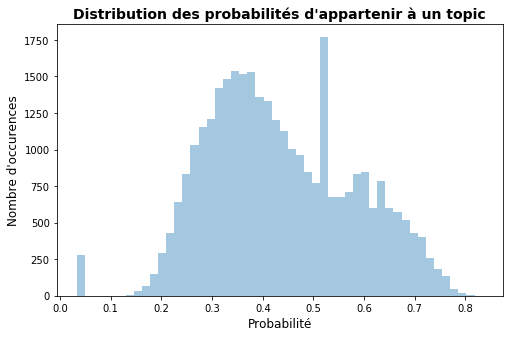

In [77]:
fig, ax = plt.subplots(figsize=(8,5))
max_proba_topic = np.max(lda_output, axis=1)
sns.distplot(df_document_topic['max_proba_topic'], kde=False)
ax.set_xlabel("Probabilité", fontsize=12)
ax.set_ylabel("Nombre d'occurences", fontsize=12)
ax.set_title("Distribution des probabilités d'appartenir à un topic", fontsize=14, weight="bold");

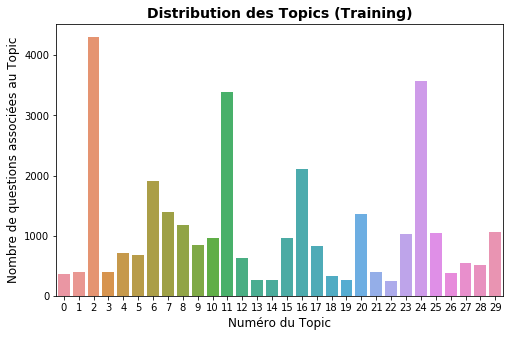

In [78]:
fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(df_document_topic["dominant_topic"])
ax.set_xlabel("Numéro du Topic", fontsize=12)
ax.set_ylabel("Nombre de questions associées au Topic", fontsize=12)
ax.set_title("Distribution des Topics (Training)", fontsize=14, weight="bold");

In [79]:
topics, counts = np.unique(df_document_topic['max_proba_topic'], return_counts=True)
main_topic = topics[np.argsort(-counts)][0]

In [80]:
#  Montre le top des mots par Topic
def show_topics(vectorizer=vectorizer, lda_model=lda, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    # Topic - Keywords Dataframe
    df_topic_keywords = pd.DataFrame(topic_keywords)
    df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
    df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]

    return df_topic_keywords

Visualisons par exemples sur plus de 10 mots

In [81]:
df_topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda, n_words=15)
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,keyboard,colour,increment,cd,ideally,consists,coco,keypress,indentation,alphanumeric,keydown,wxwidgets,keystroke,cin,backcolor
Topic 1,linux,compiler,compile,gcc,optimize,compute,dev,kernel,compilation,optimization,msbuild,window,oo,usb,rd
Topic 2,sql,database,query,server,mysql,linq,db,null,varchar,dataset,int,oracle,schema,clause,max
Topic 3,gridview,listview,cpu,firstname,header,usage,datatable,lastname,col,programmer,john,cod,bound,someclass,kb
Topic 4,algorithm,dictionary,nsstring,zend,nil,matrix,delegate,subclass,alloc,iphone,uiview,uitableview,controller,nslog,enumerate
Topic 5,ruby,pdf,api,gem,binary,wikipedia,ftp,nunit,viewstate,functionality,rb,annotation,locale,stdout,zoom
Topic 6,silverlight,grid,browser,font,binding,window,wpf,width,cs,xaml,layout,combobox,firefox,datagrid,resize
Topic 7,email,perl,delphi,desktop,window,instal,directory,graph,xp,mfc,batch,executable,cursor,setup,installer
Topic 8,xml,node,parse,encode,json,utf,parser,schema,html,namespace,cooky,xsd,td,wsdl,params
Topic 9,dll,nhibernate,lib,bash,zip,mapping,dlls,applet,bin,extract,wrapper,lazy,directory,vc,usr


Cela nous permet de voir les thèmes qui ressortent de façon assez claire.

Cherchons les principaux tags associés pour chacun des topics

In [82]:
# Intialisation de Matrice de dimension
tags_topics = np.zeros((no_topics, len(unique_tags)))

In [83]:
test_tags_topics_df = pd.DataFrame(tags_topics, columns=unique_tags, dtype='int64')
for i, topic in enumerate(df_document_topic["dominant_topic"]):
    for tag in data_train["New_tags"].iloc[i].split("/"):
        test_tags_topics_df.loc[topic, tag] += 1


In [84]:
min_frequency_tag = 0
main_tags_by_topics = test_tags_topics_df.apply(get_lda_frequent_tags, args=(min_frequency_tag,
                                                                                most_popular_tag), axis=1)

In [85]:
main_tags_by_topics_df = pd.DataFrame()
main_tags_by_topics_df['LDA Topic'] = main_tags_by_topics.index.values
main_tags_by_topics_df['Tags associés'] = main_tags_by_topics.values
word_topics = show_topics(vectorizer=vectorizer, lda_model=lda, n_words=10
                         )
word_topics.index = main_tags_by_topics_df.index.values

# On sélectionne les 5 premiers mots de chaque topic
word_topics_grouped = word_topics.apply(lambda x: '/'.join(x.dropna().values.tolist()[0:5]), axis=1)
word_topics_df = pd.DataFrame(word_topics_grouped)
word_topics_df.columns=["Topics_group"]

pd.concat([main_tags_by_topics_df, word_topics_df],axis=1)

,LDA Topic,Tags associés,Topics_group
0,0,"[c#, .net, c++, java, visual-studio]",keyboard/colour/increment/cd/ideally
1,1,"[c++, linux, c, c#, .net]",linux/compiler/compile/gcc/optimize
2,2,"[sql, sql-server, c#, mysql, database]",sql/database/query/server/mysql
3,3,"[c#, asp.net, .net, c++, winforms]",gridview/listview/cpu/firstname/header
4,4,"[iphone, objective-c, cocoa-touch, cocoa, c#]",algorithm/dictionary/nsstring/zend/nil
5,5,"[ruby, ruby-on-rails, c#, java, .net]",ruby/pdf/api/gem/binary
6,6,"[wpf, c#, .net, asp.net, silverlight]",silverlight/grid/browser/font/binding
7,7,"[c#, .net, perl, windows, delphi]",email/perl/delphi/desktop/window
8,8,"[xml, c#, .net, java, php]",xml/node/parse/encode/json
9,9,"[.net, c#, nhibernate, c++, visual-studio]",dll/nhibernate/lib/bash/zip


## Phase de prédiction -  LDA

In [86]:
lda_output_test = lda.transform(X_test)

In [87]:
topicnames = ["Topic" + str(i) for i in range(no_topics)]
# Nom des indexes
docnames_test = ["Body Title N°" + str(i) for i in range(X_test.shape[0])]

# Construction de pandas dataframe
df_document_topic_test = pd.DataFrame(np.round(lda_output_test, 3), columns=topicnames, index=docnames_test)

# Topic dominant pour chaque texte
dominant_topic_test = np.argmax(df_document_topic_test.values, axis=1)
max_proba_topic_test = np.max(lda_output_test, axis=1)
df_document_topic_test['max_proba_topic_test'] = max_proba_topic_test.round(3)
df_document_topic_test['dominant_topic_test'] = dominant_topic_test

# Mise en couleur
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Application de la mise en couleur
df_document_topics_test = df_document_topic_test.head(10).style.applymap(color_green).applymap(make_bold)
df_document_topics_test

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,max_proba_topic_test,dominant_topic_test
Body Title N°0,0.012,0.012,0.012,0.012,0.012,0.012,0.652,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.652,6
Body Title N°1,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.193,0.009,0.009,0.009,0.009,0.009,0.009,0.28,0.009,0.009,0.072,0.214,0.009,0.009,0.009,0.009,0.28,21
Body Title N°2,0.012,0.012,0.012,0.012,0.012,0.123,0.105,0.012,0.012,0.333,0.12,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.333,9
Body Title N°3,0.009,0.009,0.745,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.009,0.745,2
Body Title N°4,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.593,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.593,21
Body Title N°5,0.01,0.01,0.18,0.073,0.01,0.01,0.01,0.01,0.01,0.01,0.488,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.488,10
Body Title N°6,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.012,0.327,0.012,0.012,0.012,0.012,0.346,0.346,29
Body Title N°7,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.008,0.247,0.051,0.008,0.008,0.008,0.008,0.008,0.008,0.102,0.008,0.008,0.008,0.008,0.008,0.145,0.129,0.008,0.008,0.008,0.008,0.146,0.247,9
Body Title N°8,0.01,0.01,0.01,0.01,0.01,0.01,0.704,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.704,6
Body Title N°9,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.014,0.591,0.591,29


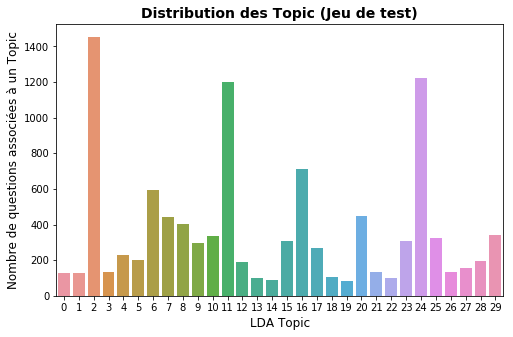

In [88]:
# Distribution des Topics (Training)
fig, ax = plt.subplots(figsize=(8,5))
sns.countplot(df_document_topic_test["dominant_topic_test"])
ax.set_xlabel("LDA Topic", fontsize=12)
ax.set_ylabel("Nombre de questions associées à un Topic", fontsize=12)
ax.set_title("Distribution des Topic (Jeu de test)", fontsize=14, weight="bold");

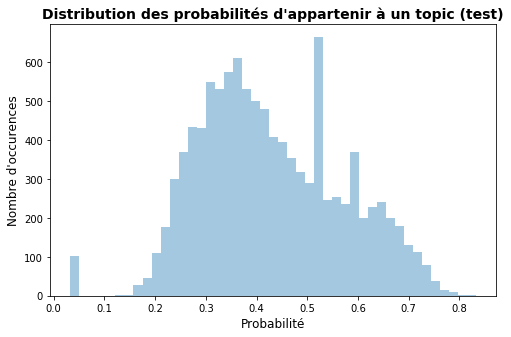

In [89]:
fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(df_document_topic_test['max_proba_topic_test'], kde=False)
ax.set_xlabel("Probabilité", fontsize=12)
ax.set_ylabel("Nombre d'occurences", fontsize=12)
ax.set_title("Distribution des probabilités d'appartenir à un topic (test)", fontsize=14, weight="bold");

Cherchons désormais à afficher à la fois nos prédictions, les tags associés et les différents scores à chaque document.

In [90]:
y_pred_lda = pd.DataFrame(dominant_topic_test, index=y_test.index, columns=['topics'])
y_pred_topic = y_pred_lda.copy()

y_pred_lda['pred_tags'] = y_pred_lda.topics.apply(lambda x: main_tags_by_topics[x])
y_pred_topic['word_topics_predicted'] = y_pred_lda.topics.apply(lambda x: word_topics_grouped[x])

y_true_tags = pd.DataFrame(data_test["New_tags"].values, index=y_test.index, columns=['true_tags'])

y_pred_lda = y_pred_lda.drop(labels=['topics'], axis=1)
y_pred_topic = y_pred_topic.drop(labels=['topics'], axis=1)

lda_comparison_df= pd.concat((y_pred_lda, y_true_tags), axis=1)
lda_comparison_df_topic= pd.concat((y_pred_topic, y_true_tags), axis=1)
lda_comparison_df.columns = ['Predicted_Tags', 'True_Tags']
lda_comparison_df_topic.columns = ["Predicted_Tags", 'True_Tags']

#  '/' join sur les tags prédits
lda_comparison_df['Predicted_Tags'] = lda_comparison_df['Predicted_Tags'].apply(lambda x: "/".join(x))
# lda_comparison_df_topic['Predicted_Tags'] = lda_comparison_df_topic['Predicted_Tags'].apply(lambda x: "/".join(x))

lda_comparison_df['Local_Recall'] = lda_comparison_df.apply(local_recall, axis=1)
lda_comparison_df_topic['Local_Recall'] = lda_comparison_df_topic.apply(local_recall, axis=1)

In [91]:
# Affichage première méthode de prédiction
display(lda_comparison_df.sample(20))
mean_local_recall(lda_comparison_df, unique_tags_serie)
other_scores(lda_comparison_df, unique_tags_serie)

,Predicted_Tags,True_Tags,Local_Recall
4668,c#/c++/.net/java/c,c++/visual-studio-2008,0.500000
6215,wpf/c#/.net/asp.net/silverlight,windows/user-interface,0.000000
7873,javascript/jquery/html/asp.net/css,jquery,1.000000
5062,c#/java/macos/.net/javascript,debugging,0.000000
1318,.net/c#/nhibernate/c++/visual-studio,c++,1.000000
489,javascript/jquery/html/asp.net/css,javascript/ajax,0.500000
2905,svn/version-control/java/c#/oracle,c#/svn,1.000000
460,javascript/jquery/html/asp.net/css,php/html/forms,0.333333
5704,c#/.net/flex/flash/actionscript-3,flash,1.000000
7740,c#/.net/asp.net/java/security,.net,1.000000


Recall moyen : 0.48
F1 Score : 0.225
Précision : 0.154


(0.22465327118111356, 0.15426234080133866)

In [92]:
# Affichage deuxième méthode de prédiction
display(lda_comparison_df_topic.sample(20))
mean_local_recall(lda_comparison_df_topic, unique_tags_serie)
other_scores(lda_comparison_df_topic, unique_tags_serie)

,Predicted_Tags,True_Tags,Local_Recall
6430,python/django/module/def/py,python,1.000000
719,parameter/validation/validate/generic/constructor,visual-studio,0.000000
10513,sql/database/query/server/mysql,c#/.net/entity-framework/.net-3.5,0.000000
2757,javascript/div/jquery/html/cs,jquery/html/debugging,0.666667
6861,python/django/module/def/py,multithreading,0.000000
4186,java/eclipse/excel/interface/gui,visual-studio,0.000000
10396,java/eclipse/excel/interface/gui,java/excel,1.000000
2145,int/void/static/null/char,python/design-patterns,0.000000
8046,gridview/listview/cpu/firstname/header,tsql,0.000000
576,int/void/static/null/char,c#/generics,0.000000


Recall moyen : 0.19


C:\Users\Windows 10\Anaconda3\envs\envapp3\lib\site-packages\sklearn\preprocessing\label.py:935: UserWarning: unknown class(es) ['app', 'asp', 'blog', 'cache', 'colour', 'compile', 'compiler', 'cs', 'ctrl', 'debug', 'debugger', 'def', 'delete', 'dependency', 'disable', 'div', 'enum', 'filename', 'firstname', 'font', 'generic', 'google', 'gui', 'ideally', 'ii', 'lib', 'mac', 'microsoft', 'mvc', 'nil', 'node', 'optimize', 'parameter', 'parse', 'password', 'py', 'query', 'server', 'socket', 'subversion', 'swf', 'tab', 'template', 'tutorial', 'txt', 'validate', 'vb', 'vista', 'webservice', 'website', 'zend'] will be ignored
  .format(sorted(unknown, key=str)))
C:\Users\Windows 10\Anaconda3\envs\envapp3\lib\site-packages\sklearn\preprocessing\label.py:935: UserWarning: unknown class(es) ['app', 'asp', 'blog', 'cache', 'colour', 'compile', 'compiler', 'cs', 'ctrl', 'debug', 'debugger', 'def', 'delete', 'dependency', 'disable', 'div', 'enum', 'filename', 'firstname', 'font', 'generic', 'googl

F1 Score : 0.116
Précision : 0.091


(0.11570428115468556, 0.0912351646989557)

Affichage des topics ainsi que les mots clés de ceux-ci.

In [93]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, X_test, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x           y  topics  cluster      Freq
topic                                                  
2     -66.097397   47.113182       1        1  9.448068
24    -11.750876  -82.037827       2        1  8.605978
11    -64.435883  -27.794672       3        1  8.591452
16    -77.751823  -65.282448       4        1  5.176819
6      18.028826   11.178862       5        1  4.778567
20     -2.614846  -46.911510       6        1  3.892118
7      42.480354  -32.183834       7        1  3.769554
8     -37.941792  -53.802425       8        1  3.690274
25     14.231407  -19.230721       9        1  3.160597
29    -48.304401    6.555450      10        1  3.151025
23     21.736555  -69.670403      11        1  3.142248
9      -2.920386 -119.652893      12        1  3.039884
15     88.916687  -37.098473      13        1  2.969181
10     79.283287  -88.887619      14        1  2.954749
17    -22.013153  -19.803551      15        1  2.787839
4     -80.889420  347.873810      16        1  2.488827
12    -15.212328   81.129799      17        1  2.365265
5      46.502838   28.781605      18        1  2.352534
28     37.542919 -105.370461      19        1  2.330388
27    -14.587119   13.141439      20        1  2.272748
21    -28.048002   44.776077      21        1  2.231340
1      76.966606   48.655231      22        1  2.178903
3      97.516121    6.146413      23        1  2.141381
26     60.155247   -3.880995      24        1  2.135773
18     56.010597  -61.647629      25        1  2.039929
14     35.479744   74.735100      26        1  1.810002
22    -46.631989  -97.472511      27        1  1.773813
19    -87.155968    4.657094      28        1  1.770140
13     86.439178 -156.766220      29        1  1.724565
0      11.637646   46.226524      30        1  1.226037, topic_info=     Category        Freq                  Term       Total  loglift  logprob
term                                                                         
2434  Default  292.000000                window  292.000000  30.0000  30.0000
1626  Default  164.000000                   php  164.000000  29.0000  29.0000
1733  Default  131.000000                python  131.000000  28.0000  28.0000
127   Default  197.000000                   asp  197.000000  27.0000  27.0000
2036  Default  193.000000                   sql  193.000000  26.0000  26.0000
2479  Default  139.000000                   xml  139.000000  25.0000  25.0000
2359  Default   86.000000                    vb   86.000000  24.0000  24.0000
1165  Default   86.000000                iphone   86.000000  23.0000  23.0000
1430  Default   82.000000                   mvc   82.000000  22.0000  22.0000
1195  Default  189.000000                  java  189.000000  21.0000  21.0000
646   Default   78.000000                   dll   78.000000  20.0000  20.0000
1235  Default   58.000000              keyboard   58.000000  19.0000  19.0000
261   Default   66.000000                 cache   66.000000  18.0000  18.0000
1883  Default   77.000000                  ruby   77.000000  17.0000  17.0000
1797  Default   65.000000                 regex   65.000000  16.0000  16.0000
2149  Default   60.000000                   tab   60.000000  15.0000  15.0000
1739  Default  134.000000                 query  134.000000  14.0000  14.0000
506   Default  183.000000              database  183.000000  13.0000  13.0000
611   Default   54.000000                dialog   54.000000  12.0000  12.0000
552   Default   77.000000                 debug   77.000000  11.0000  11.0000
641   Default   88.000000                   div   88.000000  10.0000  10.0000
441   Default   75.000000            controller   75.000000   9.0000   9.0000
2173  Default   65.000000              template   65.000000   8.0000   8.0000
1126  Default  142.000000                   int  142.000000   7.0000   7.0000
1278  Default   66.000000                 linux   66.000000   6.0000   6.0000
2401  Default   53.000000                   wcf   53.000000

# Classification Supervisée MULTI LABEL

## Régression logistique

In [94]:
import shutil
import glob
import os
current_path = os.getcwd()
parent_path = os.path.dirname(current_path)
reg_log_path = parent_path + '\\classifiers\\logistical_regression'

if os.path.exists(reg_log_path):
    shutil.rmtree(reg_log_path)
os.mkdir(reg_log_path)

classifiers = []
count=1
for category in selected_tags:
    print("{}/{} - Entrainement sur le Tag: '{}' ...".format(count, len(selected_tags),category))
# Sélection du classifieur
    clf = linear_model.LogisticRegression(random_state=0)
    clf = clf.fit(X_train, y_train[category])
    joblib.dump(clf, reg_log_path + "\\reglog_"+category + ".pkl") # On sauvegarde notre encodage pour une utilisation ultérieure
    classifiers.append(clf)
    count=count+1


1/99 - Entrainement sur le Tag: 'c#' ...
2/99 - Entrainement sur le Tag: '.net' ...
3/99 - Entrainement sur le Tag: 'java' ...
4/99 - Entrainement sur le Tag: 'asp.net' ...
5/99 - Entrainement sur le Tag: 'javascript' ...
6/99 - Entrainement sur le Tag: 'c++' ...
7/99 - Entrainement sur le Tag: 'php' ...
8/99 - Entrainement sur le Tag: 'python' ...
9/99 - Entrainement sur le Tag: 'sql' ...
10/99 - Entrainement sur le Tag: 'sql-server' ...
11/99 - Entrainement sur le Tag: 'jquery' ...
12/99 - Entrainement sur le Tag: 'html' ...
13/99 - Entrainement sur le Tag: 'iphone' ...
14/99 - Entrainement sur le Tag: 'mysql' ...
15/99 - Entrainement sur le Tag: 'windows' ...
16/99 - Entrainement sur le Tag: 'asp.net-mvc' ...
17/99 - Entrainement sur le Tag: 'c' ...
18/99 - Entrainement sur le Tag: 'wpf' ...
19/99 - Entrainement sur le Tag: 'css' ...
20/99 - Entrainement sur le Tag: 'ruby-on-rails' ...
21/99 - Entrainement sur le Tag: 'visual-studio' ...
22/99 - Entrainement sur le Tag: 'database' .

In [95]:
print("Prédiction de la probabilité pour chaque question d'appartenir à Tag donné en cours de traitement...")

test_predictions = []
count = 1
zero_array = np.zeros((X_test.shape[0]))
for classifier in classifiers:
#     print("trclassifieur {} / {}".format(count, len(classifiers)))
    prediction = classifier.predict_proba(X_test)

    if prediction.shape[1] == 2:
        test_predictions.append(prediction[:,1])
    elif prediction.shape[1] == 1:
        test_predictions.append(zero_array)
    count += 1
print("Traitement terminé !")

Prédiction de la probabilité pour chaque question d'appartenir à Tag donné en cours de traitement...
Traitement terminé !


### Optimisation du seuil

Nous décions d'introduire un seuil. Pour éviter d’obtenir des prédictions forcées, nous avons introduit un seuil en dessous duquel les probabilités prédites seront jugées trop faibles pour donner un résultat concluant. Comment déterminer le seuil ?

In [96]:
thresh_list = np.linspace(0, 1, 20)
local_recall_list = []
f1_score_list = []
accuracy_list = []
count=1
for threshold in thresh_list:
    print(count)
    # Convertion en Dataframe
    test_predictions_df = pd.DataFrame(np.array(test_predictions).T, columns=y_test.columns)
    # threshold
    trusted_threshold = threshold
    # Condition sur treshold
    test_predictions_df_thresh = test_predictions_df.copy()
    test_predictions_df_thresh[test_predictions_df_thresh < trusted_threshold] = 0

    # On récupère les nouveaux tags dans une dataframe
    y_test_new_tags = pd.DataFrame(data_test["New_tags"].values, columns=["True_Tags"])
    
    # Classement des tags du plus au moins probable
    y_pred = test_predictions_df_thresh.apply(get_top_probable_tags, args=(selected_tags,), axis=1)
    y_pred.index = y_test_new_tags.index
    
    # Concatenation
    comparison_df = pd.concat((y_pred, y_test_new_tags), axis=1)
    comparison_df.columns = ['Predicted_Tags', 'True_Tags']
    # Calcul des cores
    temp_f1_score, accuracy = other_scores(comparison_df, unique_tags_serie)
    temp_local_recall = mean_local_recall(comparison_df, unique_tags_serie)
    
    # Remplissage des listes
    local_recall_list.append(temp_local_recall)
    accuracy_list.append(accuracy)
    f1_score_list.append(temp_f1_score)
    count+=1

1
F1 Score : 0.376
Précision : 0.259
Recall moyen : 0.80
2
F1 Score : 0.462
Précision : 0.363
Recall moyen : 0.77
3
F1 Score : 0.531
Précision : 0.488
Recall moyen : 0.68
4
F1 Score : 0.539
Précision : 0.543
Recall moyen : 0.62
5
F1 Score : 0.530
Précision : 0.566
Recall moyen : 0.56
6
F1 Score : 0.517
Précision : 0.576
Recall moyen : 0.52
7
F1 Score : 0.498
Précision : 0.570
Recall moyen : 0.49
8
F1 Score : 0.481
Précision : 0.564
Recall moyen : 0.46
9
F1 Score : 0.464
Précision : 0.553
Recall moyen : 0.44
10
F1 Score : 0.448
Précision : 0.541
Recall moyen : 0.42
11
F1 Score : 0.432
Précision : 0.527
Recall moyen : 0.40
12
F1 Score : 0.416
Précision : 0.512
Recall moyen : 0.38
13
F1 Score : 0.400
Précision : 0.497
Recall moyen : 0.36
14
F1 Score : 0.381
Précision : 0.477
Recall moyen : 0.34
15
F1 Score : 0.363
Précision : 0.458
Recall moyen : 0.32
16
F1 Score : 0.342
Précision : 0.435
Recall moyen : 0.30
17
F1 Score : 0.318
Précision : 0.408
Recall moyen : 0.28
18
F1 Score : 0.290
Pré

#### Nous cherchons à maximiser le F1_score

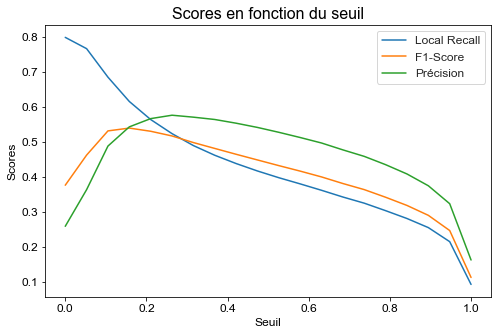

In [97]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
plt.plot(thresh_list, local_recall_list, label="Local Recall")
plt.plot(thresh_list, f1_score_list, label="F1-Score")
plt.plot(thresh_list, accuracy_list, label="Précision")
ax.set_title("Scores en fonction du seuil", fontsize=16)
ax.set_xlabel("Seuil", fontsize=12)
ax.set_ylabel("Scores", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12);

In [98]:
print("F1-Score le plus élevé : {}".format(f1_score_list[np.argmax(f1_score_list)]))
print( "Treshold retenu (Régression logistique : {}".format(thresh_list[np.argmax(f1_score_list)]))
print("Local Recall moyen associée : {}".format(local_recall_list[np.argmax(f1_score_list)]))
print("Précision associée : {}".format(accuracy_list[np.argmax(f1_score_list)]))


F1-Score le plus élevé : 0.5391502912094155
Treshold retenu (Régression logistique : 0.15789473684210525
Local Recall moyen associée : 0.6151544730563031
Précision associée : 0.5426358030429798


In [99]:
# On convertit en pd.dataframe
test_predictions_df = pd.DataFrame(np.array(test_predictions).T, columns=y_test.columns)
# threshold
trusted_threshold = thresh_list[np.argmax(f1_score_list)]
# Map threshold
test_predictions_df_thresh = test_predictions_df.copy()
test_predictions_df_thresh[test_predictions_df_thresh < trusted_threshold] = 0

In [100]:
# Construction des tags prédites à partir de classifieurs,
# si il y en a plus de 5 nous conservons les 5 premiers avec la probabilité la plus forte
y_pred_ml = test_predictions_df_thresh.apply(get_top_probable_tags, args=(selected_tags,), axis=1)

# conversion en pd.dataframe
y_pred_ml = pd.DataFrame(y_pred_ml,columns=['Predicted_Tags'])

# On récupère les nouveaux tags dans une dataframe
y_test_new_tags = pd.DataFrame(data_test["New_tags"].values, columns=["True_Tags"])

# On construit un tableau pour comparer tags prédits et nouveaux tags
multilabel_comparison_df = pd.concat([y_test_new_tags, y_pred_ml], axis=1)

# On applique la fonction qui nous donne nombre de mots-clés justes parmi N mots-clés prédits
multilabel_comparison_df['Local_Recall'] = multilabel_comparison_df.apply(local_recall, axis=1)

# Affichages
display(multilabel_comparison_df.sample(20))
display(mean_local_recall(multilabel_comparison_df, unique_tags_serie))
display(other_scores(multilabel_comparison_df, unique_tags_serie))



,True_Tags,Predicted_Tags,Local_Recall
6975,svn/version-control,svn/version-control,1.000000
1041,java,java,1.000000
10602,flex,flex/actionscript-3,1.000000
4174,javascript/jquery,html/jquery,0.500000
6963,mysql/sql,.net,0.000000
9909,php/ajax,php/javascript,0.500000
7848,javascript/events,javascript,0.500000
10358,php/regex,regex/php,1.000000
1516,ruby-on-rails/ruby,c#/.net,0.000000
6230,asp.net-mvc,asp.net-mvc/asp.net,1.000000


Recall moyen : 0.62


0.6151544730563031

F1 Score : 0.539
Précision : 0.543


(0.5391502912094155, 0.5426358030429798)

#### Courbes ROC

In [ ]:
from sklearn.metrics import roc_curve, auc
plt.subplots(figsize=(10,6))
auc_list = []
for indice in range(len(selected_tags)):
    tag_to_classify = y_test.columns[indice]
    fpr, tpr, _ = metrics.roc_curve(y_test[tag_to_classify], test_predictions_df[tag_to_classify])
    auc = metrics.roc_auc_score(y_test[tag_to_classify],  test_predictions_df[tag_to_classify])

    plt.plot(fpr,tpr,label=tag_to_classify+", auc="+str(auc),color='darkorange', lw=0.6)
    auc_list.append(auc)
plt.title('Sensibilité en fonction de 1-spécificité - Régression logistique', fontsize=14)
plt.xlabel('1 - specificite', fontsize=14)
plt.ylabel('Sensibilité (Recall)', fontsize=14)
plt.show()

auc_df = pd.DataFrame(auc_list)
auc_df.index = selected_tags
auc_df.columns=["Score Auc"]
# display(auc_df.head(15))
display("Moyenne AUC : {}".format((auc_df["Score Auc"].mean())))

# plt.subplots(figsize=(6,4))
# plt.scatter(range(len(temp)), temp["Score Auc"])

## Naive Bayes

In [ ]:
current_path = os.getcwd()
parent_path = os.path.dirname(current_path)
nb_path = parent_path + '\\classifiers\\naive_bayes'

if os.path.exists(nb_path):
    shutil.rmtree(nb_path)
os.mkdir(nb_path)

classifiers = []
count=1
for category in selected_tags:
    print("{}/{} - Entrainement sur le Tag: '{}' ...".format(count, len(selected_tags),category))
# Sélection du classifieur
    clf = MultinomialNB(fit_prior=True, class_prior=None)
    clf= clf.fit(X_train, y_train[category])
    joblib.dump(clf, nb_path + "\\nb_"+category + ".pkl") # On sauvegarde notre encodage pour une utilisation ultérieure
    classifiers.append(clf)
    count=count+1


In [ ]:
print("Prédiction de la probabilité pour chaque question d'appartenir à Tag donné en cours de traitement...")
test_predictions = []
count = 1
zero_array = np.zeros((X_test.shape[0]))
for classifier in classifiers:
#     print("trclassifieur {} / {}".format(count, len(classifiers)))
    prediction = classifier.predict_proba(X_test)
    if prediction.shape[1] == 2:
        test_predictions.append(prediction[:,1])
    elif prediction.shape[1] == 1:
        test_predictions.append(zero_array)
    count += 1
print("Traitement terminé !")

#### Optimisation du seuil

In [ ]:
# Optimisation du seuil
thresh_list = np.linspace(0, 1, 20)
local_recall_list = []
f1_score_list = []
accuracy_list = []
count=1
for threshold in thresh_list:
    print(count)
    # Convertion en Dataframe
    test_predictions_df = pd.DataFrame(np.array(test_predictions).T, columns=y_test.columns)
    # threshold
    trusted_threshold = threshold
    # Condition sur treshold
    test_predictions_df_thresh = test_predictions_df.copy()
    test_predictions_df_thresh[test_predictions_df_thresh < trusted_threshold] = 0

    # On récupère les nouveaux tags dans une dataframe
    y_test_new_tags = pd.DataFrame(data_test["New_tags"].values, columns=["True_Tags"])
    
    # Classement des tags du plus au moins probable
    y_pred = test_predictions_df_thresh.apply(get_top_probable_tags, args=(selected_tags,), axis=1)
    y_pred.index = y_test_new_tags.index
    
    # Concatenation
    comparison_df = pd.concat((y_pred, y_test_new_tags), axis=1)
    comparison_df.columns = ['Predicted_Tags', 'True_Tags']
    # Calcul des cores
    temp_f1_score, accuracy = other_scores(comparison_df, unique_tags_serie)
    temp_local_recall = mean_local_recall(comparison_df, unique_tags_serie)
    
    # Remplissage des listes
    local_recall_list.append(temp_local_recall)
    accuracy_list.append(accuracy)
    f1_score_list.append(temp_f1_score)
    count+=1

In [ ]:
# Représentation des métriques (Naive Bayes)
fig, ax = plt.subplots(figsize=(8, 5))
sns.set_style("whitegrid")
plt.plot(thresh_list, local_recall_list, label="Local Recall")
plt.plot(thresh_list, f1_score_list, label="F1-Score")
plt.plot(thresh_list, accuracy_list, label="Précision")
ax.set_title("Scores en fonction du seuil", fontsize=16)
ax.set_xlabel("Seuil", fontsize=12)
ax.set_ylabel("Scores", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12);

In [ ]:
print("F1-Score le plus élevé (NB) : {}".format(f1_score_list[np.argmax(f1_score_list)]))
print( "Treshold retenu : {}".format(thresh_list[np.argmax(f1_score_list)]))
print("Local Recall moyen associée : {}".format(local_recall_list[np.argmax(f1_score_list)]))
print("Précision associée : {}".format(accuracy_list[np.argmax(f1_score_list)]))

In [ ]:
# On convertit en pd.dataframe
test_predictions_df = pd.DataFrame(np.array(test_predictions).T, columns=selected_tags)
# On utilise le threshold précedemment trouvé
trusted_threshold = thresh_list[np.argmax(f1_score_list)]
# Map threshold
test_predictions_df_thresh = test_predictions_df.copy()
test_predictions_df_thresh[test_predictions_df_thresh < trusted_threshold] = 0

In [ ]:
# Construction des tags prédites à partir de classifieurs,
# si il y en a plus de 5 nous conservons les 5 premiers avec la probabilité la plus forte
y_pred_ml = test_predictions_df_thresh.apply(get_top_probable_tags, args=(selected_tags,), axis=1)

# conversion en pd.dataframe
y_pred_ml = pd.DataFrame(y_pred_ml,columns=['Predicted_Tags'])

# On récupère les nouveaux tags dans une dataframe
y_test_new_tags = pd.DataFrame(data_test["New_tags"].values, columns=["True_Tags"])

# On construit un tableau pour comparer tags prédits et nouveaux tags
multilabel_comparison_df = pd.concat([y_test_new_tags, y_pred_ml], axis=1)

# On applique la fonction qui nous donne nombre de mots-clés justes parmi N mots-clés prédits
multilabel_comparison_df['Local_Recall'] = multilabel_comparison_df.apply(local_recall, axis=1)

# Affichages
display(multilabel_comparison_df.sample(20))
display(mean_local_recall(multilabel_comparison_df, unique_tags_serie))
display(other_scores(multilabel_comparison_df, unique_tags_serie))

### Random Forest

In [ ]:
current_path = os.getcwd()
parent_path = os.path.dirname(current_path)
rf_path = parent_path + '\\classifiers\\random_forest'

if os.path.exists(rf_path):
    shutil.rmtree(rf_path)
os.mkdir(rf_path)


classifiers = []
count=1
for category in selected_tags:
    print("{}/{} - Entrainement sur le Tag: '{}' ...".format(count, len(selected_tags),category))
# Sélection du classifieur
    clf = ensemble.RandomForestClassifier(n_estimators = 10) 
    clf= clf.fit(X_train, y_train[category])
    joblib.dump(clf, rf_path + "\\rf_"+category + ".pkl") # On sauvegarde notre encodage pour une utilisation ultérieure
    classifiers.append(clf)
    count=count+1


In [ ]:
print("Prédiction de la probabilité pour chaque question d'appartenir à Tag donné en cours de traitement...")
test_predictions = []
count = 1
zero_array = np.zeros((X_test.shape[0]))
for classifier in classifiers:
    prediction = classifier.predict_proba(X_test)

    if prediction.shape[1] == 2:
        test_predictions.append(prediction[:,1])
    elif prediction.shape[1] == 1:
        test_predictions.append(zero_array)
    count += 1
print("Prédictions terminés !")

In [ ]:
# On convertit en pd.dataframe
test_predictions_df = pd.DataFrame(np.array(test_predictions).T, columns=y_test.columns)
# threshold
trusted_threshold = 0.02
# Map threshold
test_predictions_df_thresh = test_predictions_df.copy()
test_predictions_df_thresh[test_predictions_df_thresh < trusted_threshold] = 0

In [ ]:
# Construction des tags prédites à partir de classifieurs,
# si il y en a plus de 5 nous conservons les 5 premiers avec la probabilité la plus forte
y_pred_ml = test_predictions_df_thresh.apply(get_top_probable_tags, args=(selected_tags,), axis=1)

# Conversion en pd.dataframe
y_pred_ml = pd.DataFrame(y_pred_ml,columns=['Predicted_Tags'])

# On récupère les nouveaux tags dans une dataframe
y_test_new_tags = pd.DataFrame(data_test["New_tags"].values, columns=["True_Tags"])

# On construit un tableau pour comparer tags prédits et nouveaux tags
multilabel_comparison_df = pd.concat([y_test_new_tags, y_pred_ml], axis=1)

# On applique la fonction qui nous donne nombre de mots-clés justes parmi N mots-clés prédits
multilabel_comparison_df['Local_Recall'] = multilabel_comparison_df.apply(local_recall, axis=1)

# Affichages
display(multilabel_comparison_df.sample(20))
display(mean_local_recall(multilabel_comparison_df, unique_tags_serie))
display(other_scores(multilabel_comparison_df, unique_tags_serie))

# Résultats et comparaison des 2 modèles

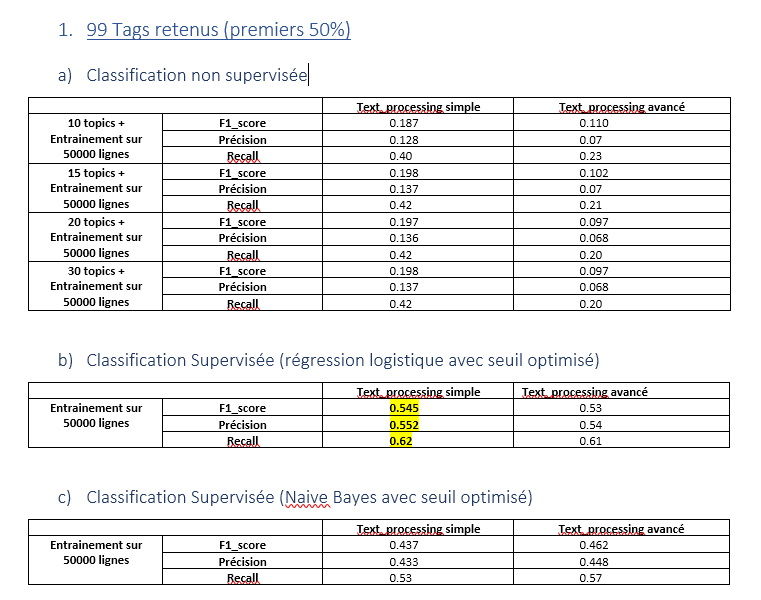

## Remarques

Le F1-Score est calculé comme suit à partir des précisions et rappels (recall)

 
•	A travers les résultats obtenus, nous pouvons privilégier la méthode supervisée de type régression logistique.

•	Clairement, la méthode non supervisée ne donne pas de bons résultats. Ainsi pour un recall élevé la précision sera assez faible, le F1-Score sera assez faible quel que soit le nombre de topic choisis. On remarque que cette méthode est plus sensible cependant au text processing avancé qui a plutôt tendance à réduire les scores obtenus lorsqu’il est appliqué.

•	Il est à noter également que le text processing avancé ne produit pas nécessairement de meilleurs résultats. Cela montre que le TF-IDF est assez efficace pour retirer les mots qui ne sont pas importants.

•	On remarque aussi clairement que si on augmente le nombre de tags sélectionnés les résultats sont moins bons ce qui est assez logique car si le choix de tags diminue, l’algorithme a moins de chances de se « tromper ».  Retenir 99 tags (ceux qui représentent 50% des apparitions) est un bon compromis.

Nous avons maintenant les bons paramètres pour notre API.


# Conclusion


Le modèle choisi pour notre API est le modèle de régression logistique dans le cadre d’une classification supervisée. 

Nous avons tenté d’être le plus rigoureux possible sur la phase de nettoyage des données car celle-ci nécessite une attention particulière pour l’entrainement des données. Cependant cette tâche peut prendre un temps important et peut  donner l’impression d’être inutile voire tirer les résultats vers le bas au-delà d’un certain point. 

Il est à noter que faire appel à la transformation TF-IDF peut faciliter grandement la tâche et réduire le temps de traitement du texte en amont. 
